Timeseries and Seasonal Decomposition

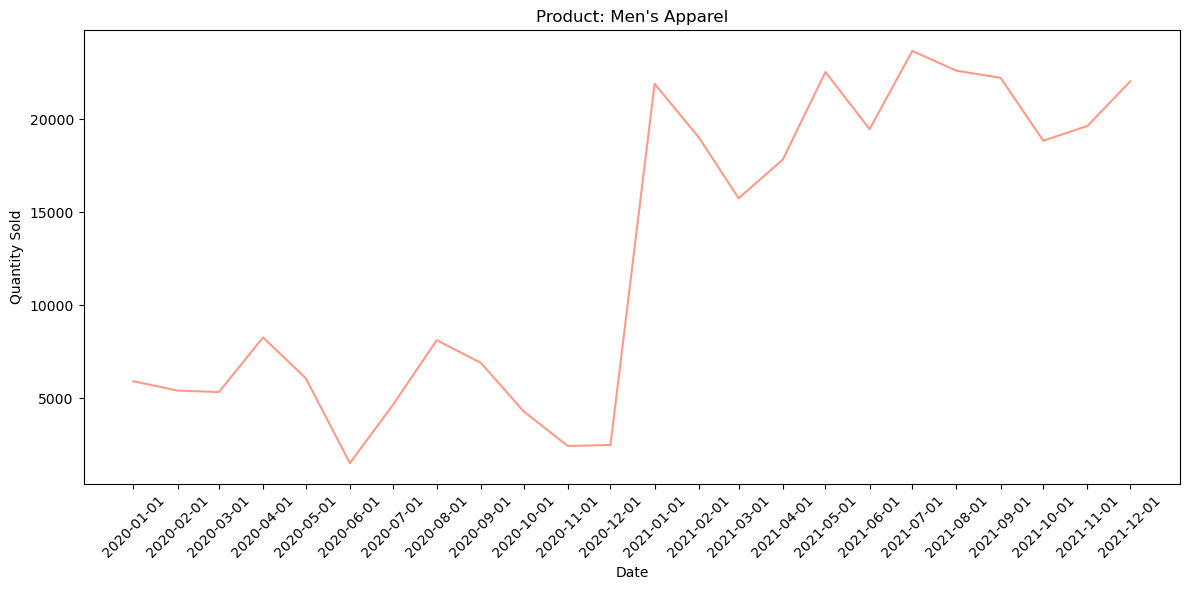

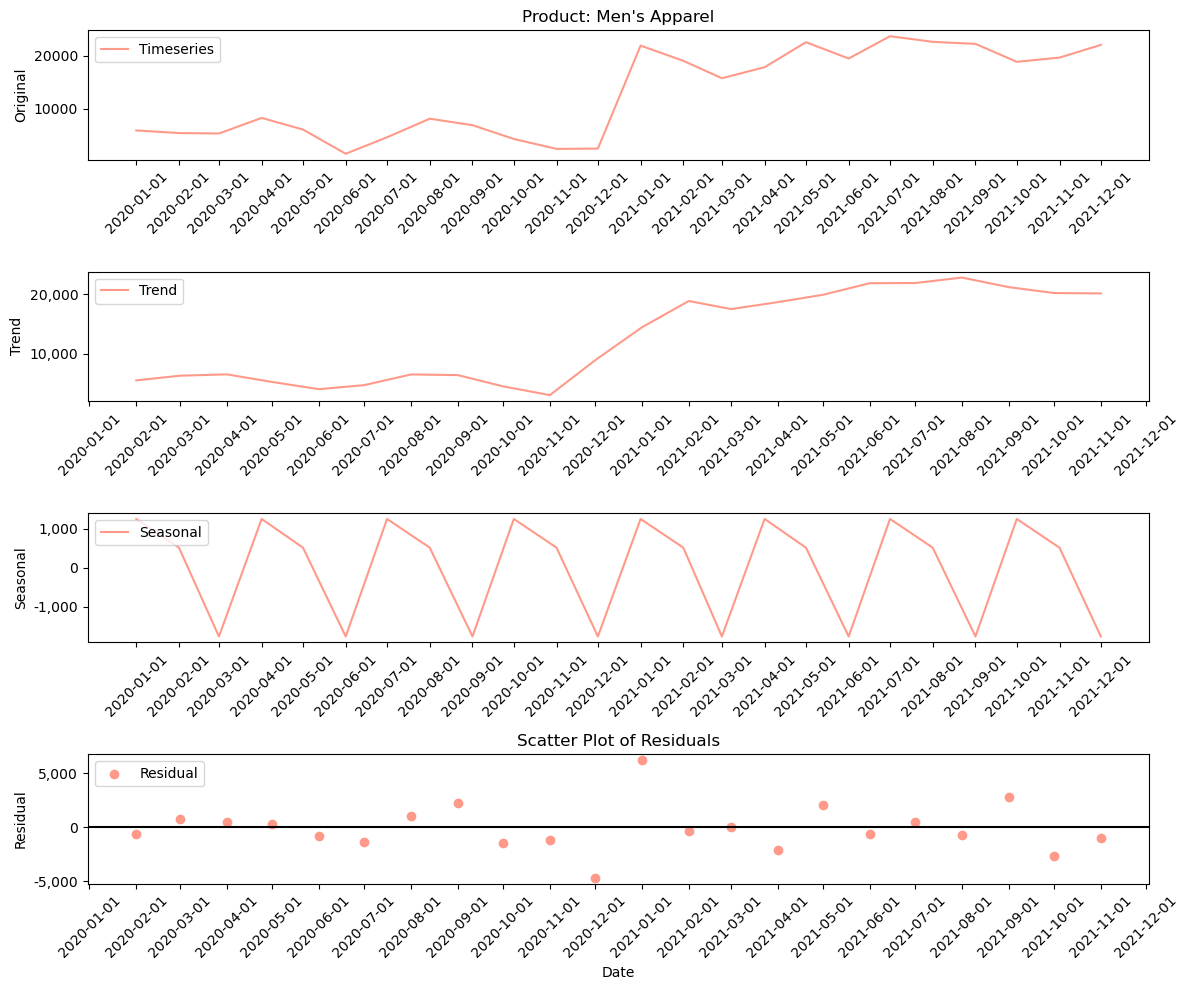

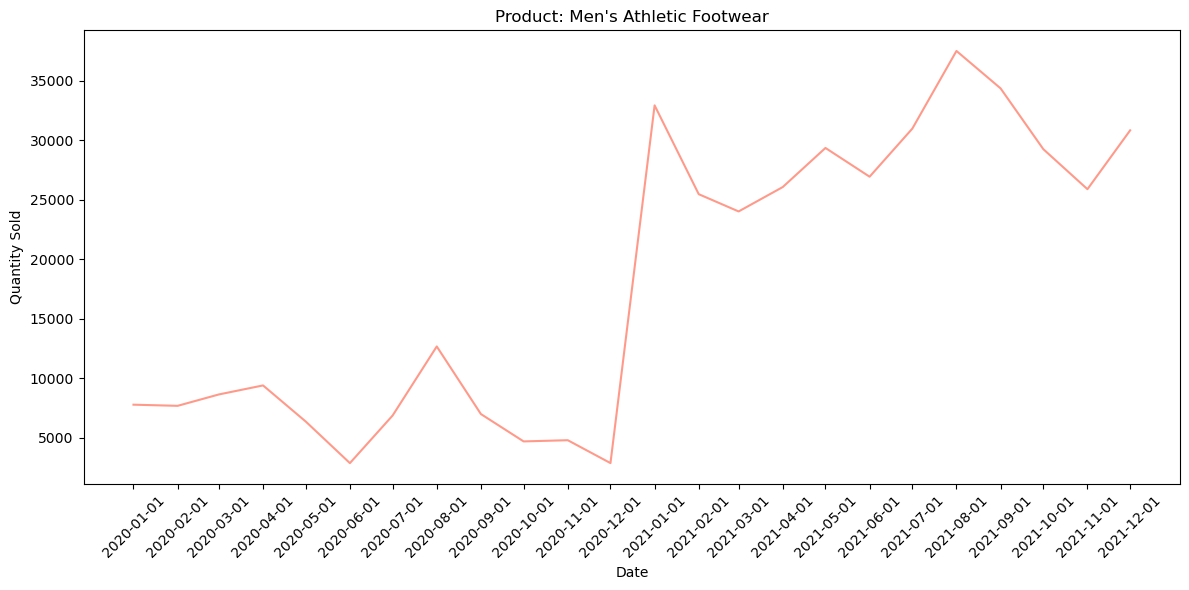

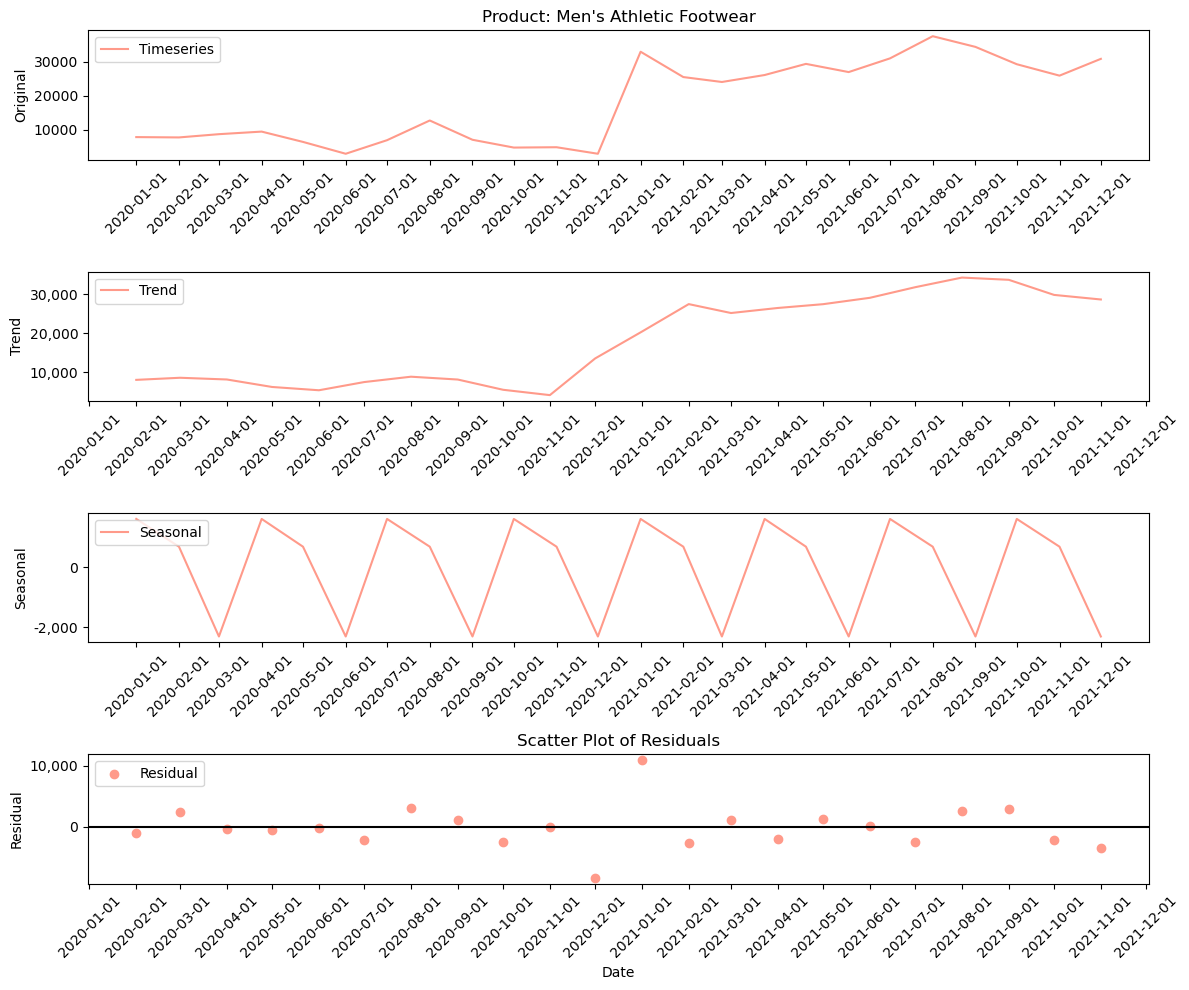

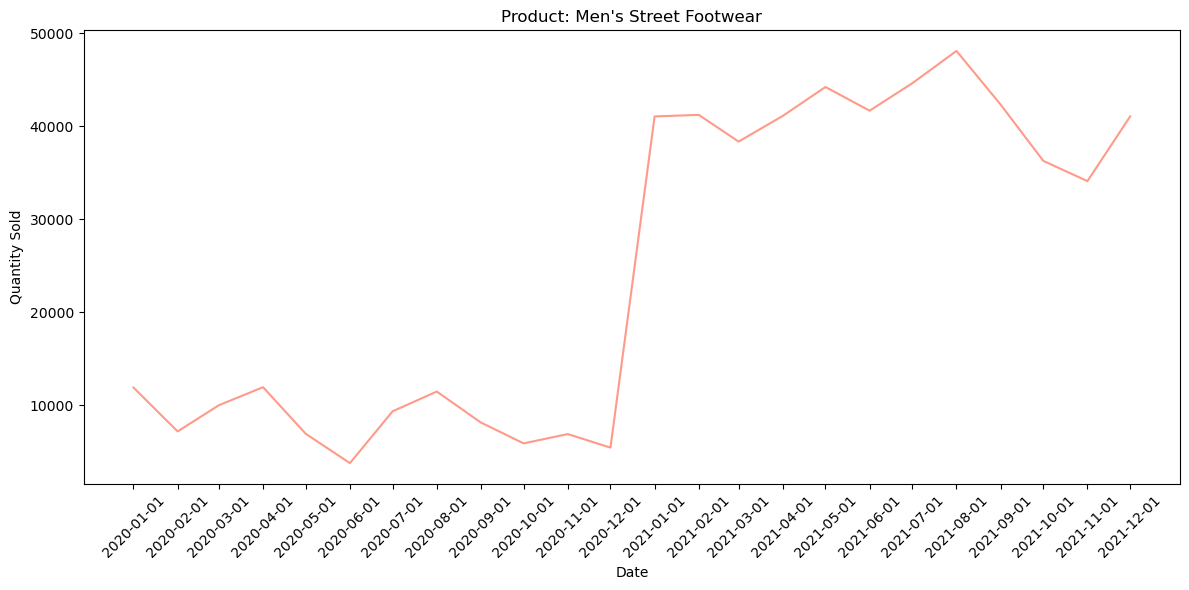

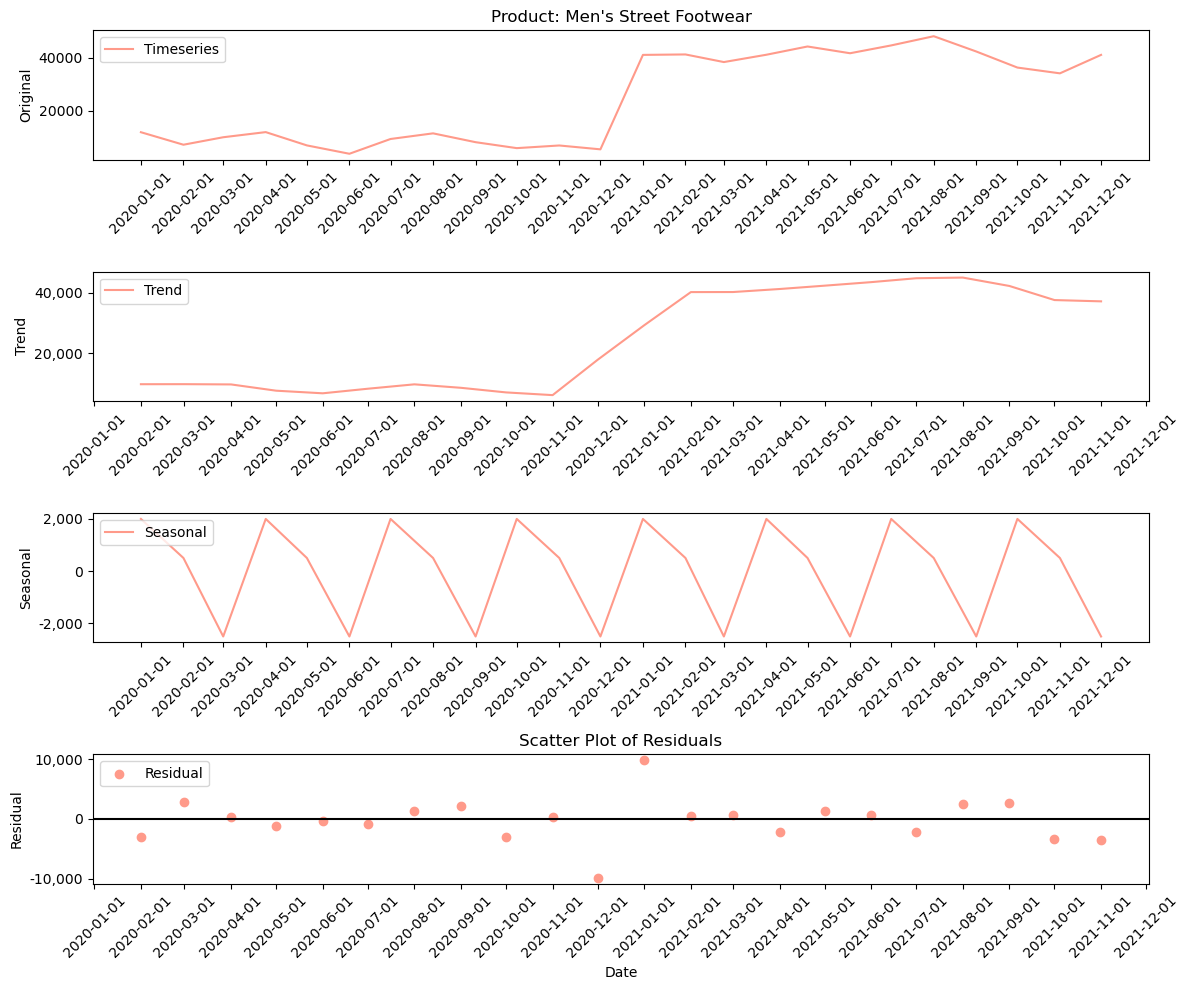

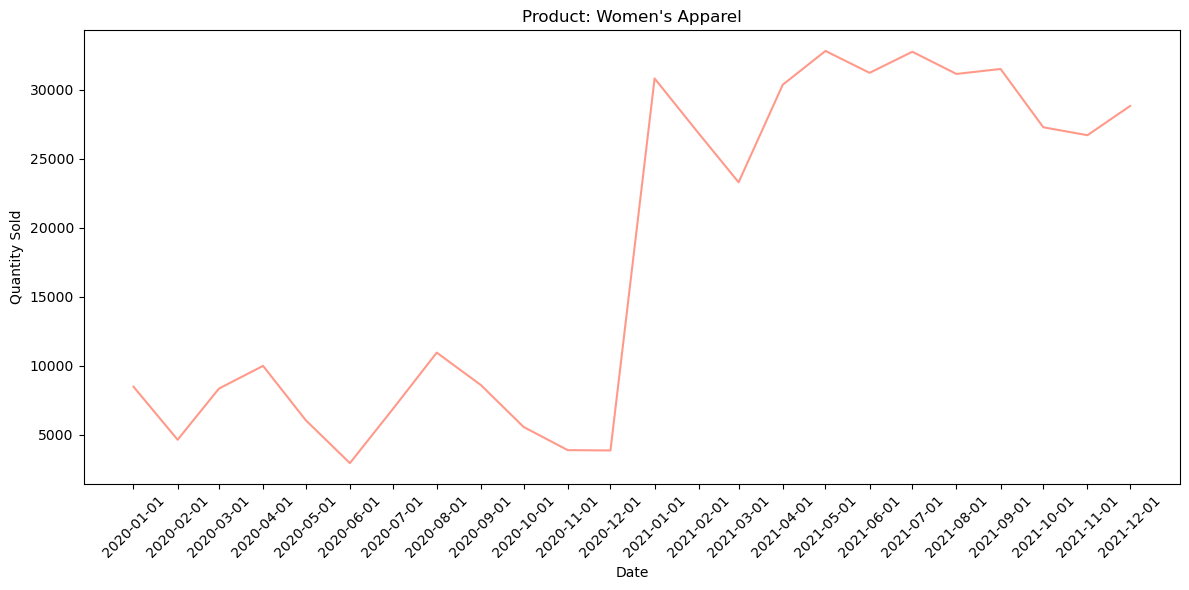

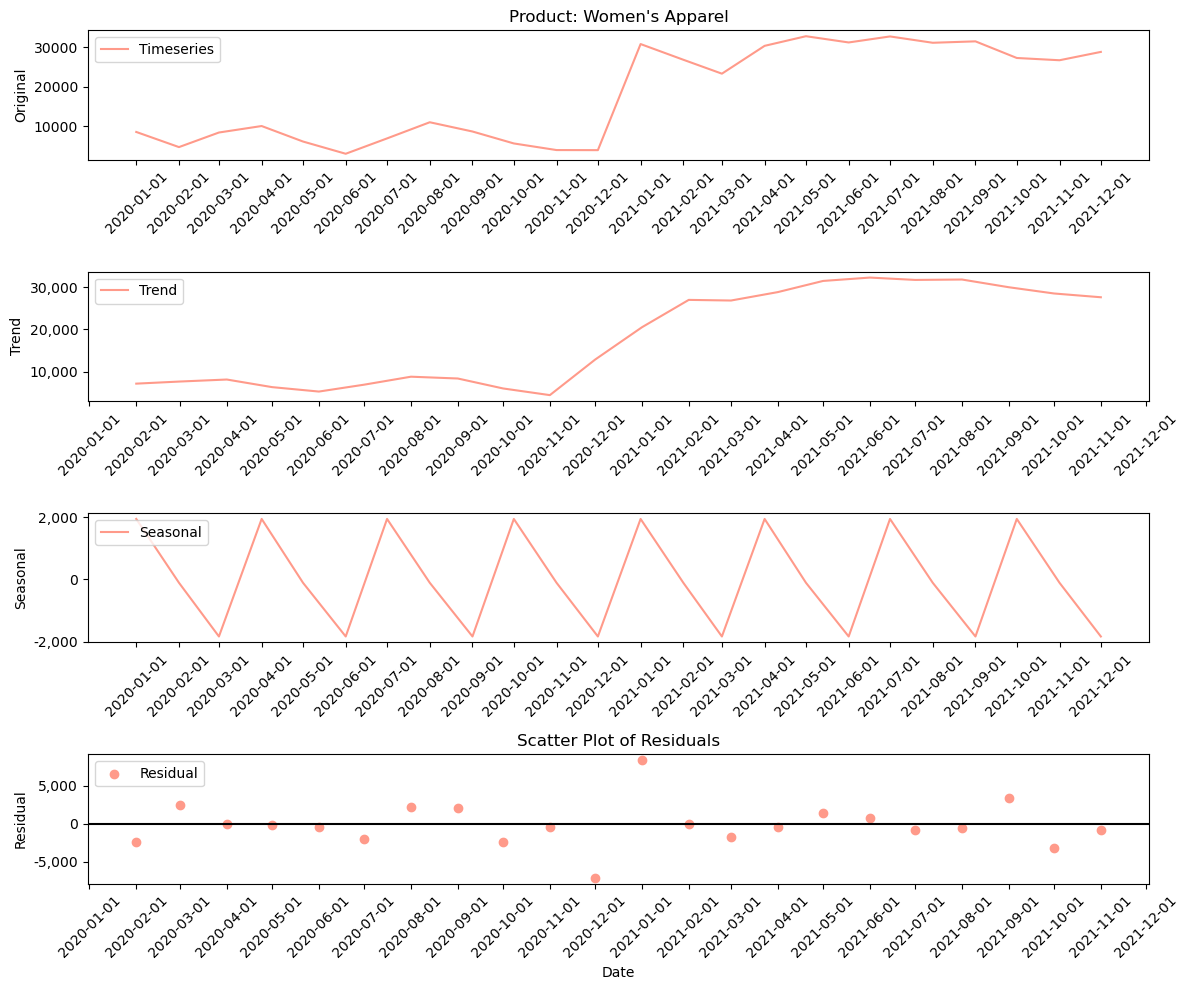

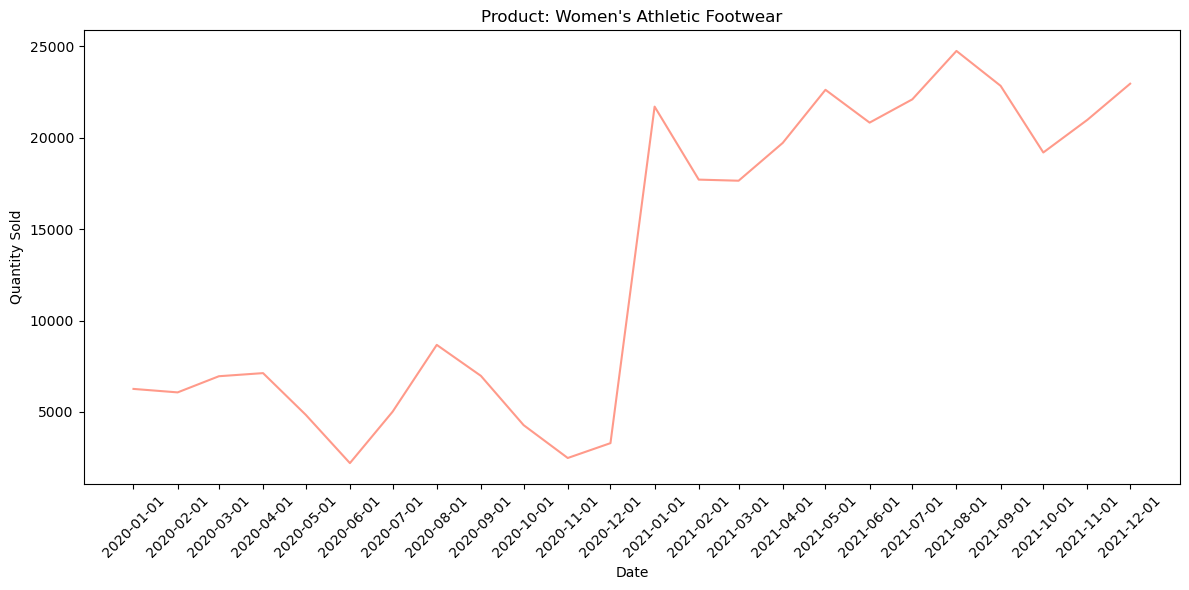

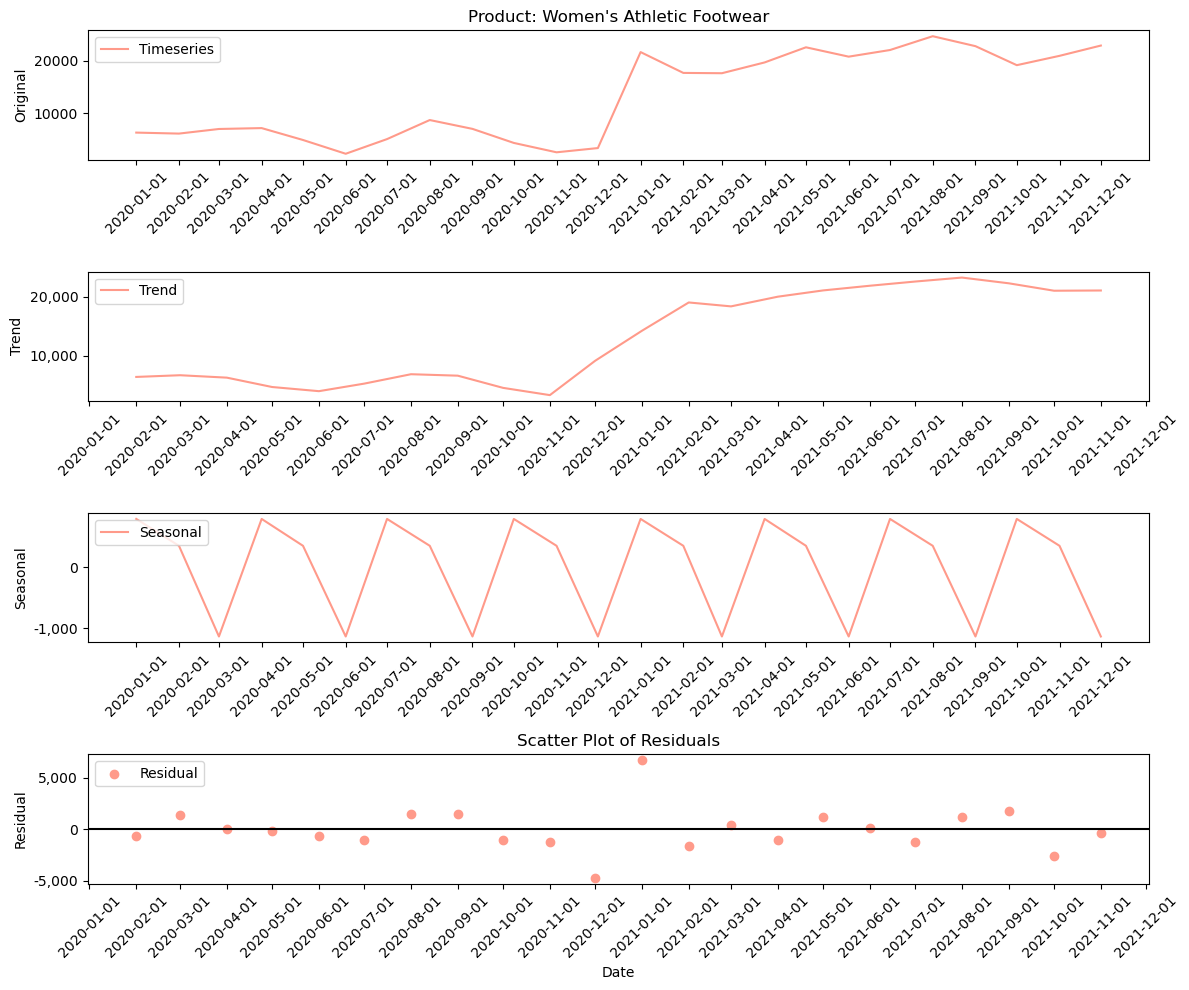

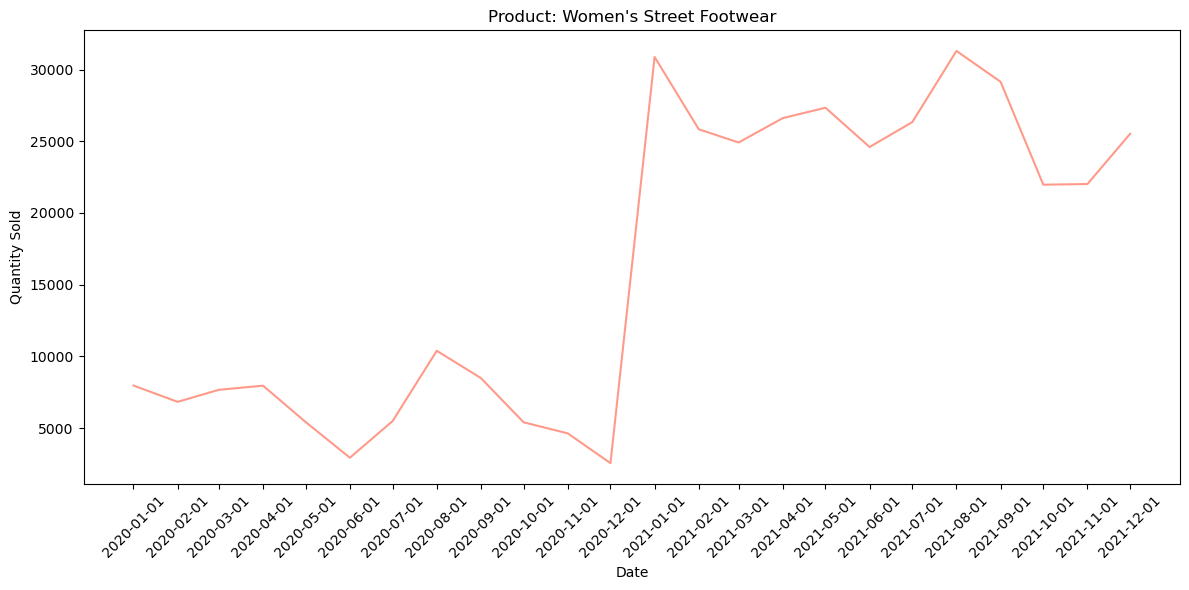

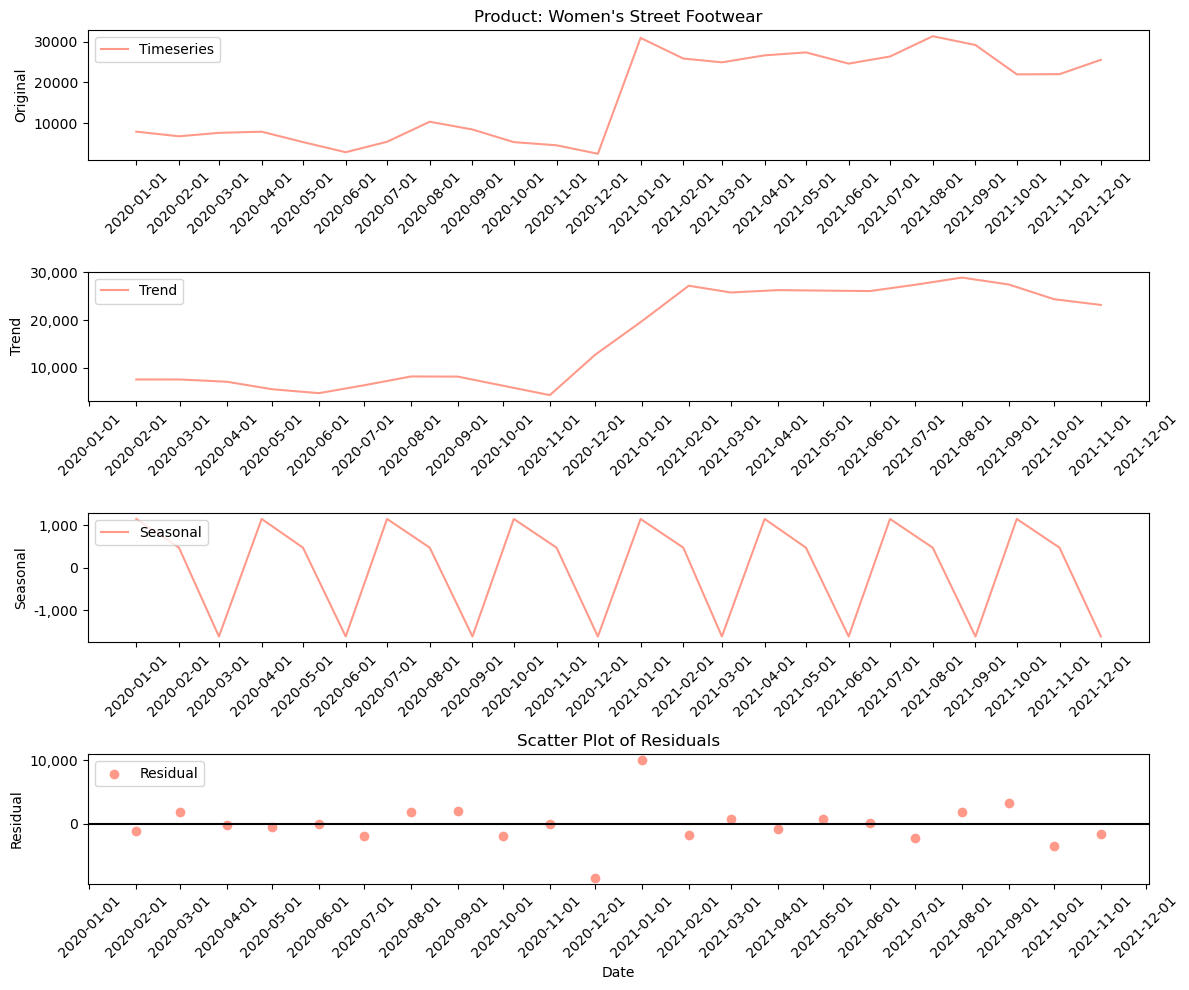

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose


df=pd.read_csv('ADS.csv')

# Convert the date column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Ensure index is sorted
df.sort_values(by=['Product', 'Date'], inplace=True)

# Drop rows with NaN values in 'Product' and 'Units Sold' columns
df.dropna(subset=['Product', 'Units Sold'], inplace=True)

# Convert 'Units Sold' to numeric (if needed)
df['Units Sold'] = pd.to_numeric(df['Units Sold'])

# Get unique Product Names
product_wise = df['Product'].unique()

# Iterate over Product Names
for pro in product_wise:
    product_df = df[df['Product'] == pro]
    
    # Time Series
    plt.figure(figsize=(12, 6))  # Adjust the figure size as per your preference
    plt.plot(product_df['Date'], product_df['Units Sold'], label='Actual Data', color='#FF9A8A')
    plt.xlabel('Date')
    plt.ylabel('Quantity Sold')
    plt.xticks(product_df['Date'], rotation=45)  # Rotate x-axis labels for better readability and ensure all dates are shown
    plt.title(f'Product: {pro}')
    plt.tight_layout()
    plt.show()

    # Seasonal Decomposition
    decomposition = seasonal_decompose(product_df['Units Sold'], model='additive', period=3)
    # Plot the decomposition
    plt.figure(figsize=(12, 10))
    plt.subplot(411)
    plt.plot(product_df['Date'], product_df['Units Sold'], label='Timeseries', color='#FF9A8A')
    plt.ylabel('Original')
    plt.legend(loc='upper left')
    plt.title(f'Product: {pro}')
    plt.xticks(product_df['Date'], rotation=45)
    plt.subplot(412)
    plt.plot(product_df['Date'], decomposition.trend, label='Trend', color='#FF9A8A')
    plt.ylabel('Trend')
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    plt.legend(loc='upper left')
    plt.xticks(product_df['Date'], rotation=45)
    plt.subplot(413)
    plt.plot(product_df['Date'], decomposition.seasonal, label='Seasonal', color='#FF9A8A')
    plt.ylabel('Seasonal')
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    plt.legend(loc='upper left')
    plt.xticks(product_df['Date'], rotation=45)
    plt.subplot(414)
    plt.scatter(product_df['Date'], decomposition.resid, label='Residual', color='#FF9A8A')
    # Add y=0 axis line
    plt.axhline(y=0, color='black', linestyle='-')
    # Labeling and legend
    plt.xlabel('Date')
    plt.ylabel('Residual')
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    plt.legend(loc='upper left')
    plt.title('Scatter Plot of Residuals')
    plt.xticks(product_df['Date'], rotation=45)
    plt.tight_layout()
    plt.show()


Holt-Winter's Demand forecasting model with Hyperparameter tuning:
    From seasonal decomposition, it is found that the dataset follows additive trend with number of seasonal periods as 3 and utilised in the model.Sales is forecasted for next 12 months from the end date of test set using the default hyperparameters.

In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from itertools import product
import warnings

warnings.filterwarnings("ignore")

# Load the dataset (assuming 'df' is your DataFrame containing the required columns)
data = pd.read_csv('ADS.csv')

# Convert the 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Get unique product names
product_wise = data['Product'].unique()

# Create a folder to save results
output_folder = "output_results"
os.makedirs(output_folder, exist_ok=True)

# Initialize DataFrame to store results
combined_df = pd.DataFrame(columns=['Product', 'Date', 'Actual Quantity Sold', 'Predicted Quantity'])
forecast_df = pd.DataFrame(columns=['Product', 'Forecast Date', 'Forecasted Quantity'])

seasonal_period=3


# Iterate over each product
for pro in product_wise:
    print("Product Name:", pro)
    product_data = data[data['Product'] == pro].reset_index(drop=True)

    # Check if there is enough data for this product
    if len(product_data) < 24:  # Adjust based on your specific requirements
        print(f"Not enough data for product {pro}")
        continue

    # Split data into train and test sets
    train = product_data.iloc[:18]  # Assuming first 18 months for training
    test = product_data.iloc[18:]   # Remaining data for testing and forecasting

    try:
        # Initialize lists to store MAPE for each combination of hyperparameters
        mape_dict = {}

       

          
        # Fit Holt-Winters model
        model = ExponentialSmoothing(train['Units Sold'], trend='add', seasonal='add', seasonal_periods=seasonal_period)
        fit = model.fit()
        preds = fit.forecast(len(test) + 12)  # Forecast for the test data plus 12 months

        # Replace negative predictions with zero
        preds[preds < 0] = 0

        # Calculate evaluation metrics for test data
        test_actual = test['Units Sold']
        test_predicted = preds[:len(test)]
        test_mape = np.mean(np.abs((test_actual - test_predicted) / (test_actual + 1))) * 100  # Add 1 to avoid division by zero
        test_mape = test_mape if not np.isnan(test_mape) else 0  # Replace NaN with 0

        # Print test evaluation metrics
        print("Test MAPE:", test_mape)
        print()

        # Store predictions in the combined_df for the test period only (July 2021 to December 2021)
        combined_dates = test['Date']
        combined_actuals = test['Units Sold']
        combined_preds = preds[:len(test)]
        combined_data = pd.DataFrame({
            'Product': pro,
            'Date': combined_dates,
            'Actual Quantity Sold': combined_actuals,
            'Predicted Quantity': combined_preds
        })
        combined_df = pd.concat([combined_df, combined_data], ignore_index=True)

        # Store forecasted quantities in the forecast_df
        forecast_dates = pd.date_range(start=test['Date'].iloc[-1] +  pd.DateOffset(months=1), periods=12, freq='MS')
        forecast_data = pd.DataFrame({
            'Product': pro,
            'Forecast Date': forecast_dates,
            'Forecasted Quantity': preds[len(test):]  # Forecasted values for the next 12 months
        })
        forecast_df = pd.concat([forecast_df, forecast_data], ignore_index=True)

        


    except Exception as e:
        print(f"Error processing product {pro}: {e}")

# Save combined results to CSV files
combined_df.to_csv(os.path.join(output_folder, "no_parameter_tuning_combined_results.csv"), index=False)
forecast_df.to_csv(os.path.join(output_folder, "no_parameter_tuning_forecast_results.csv"), index=False)


Product Name: Men's Apparel
Test MAPE: 18.77618132932971

Product Name: Men's Athletic Footwear
Test MAPE: 17.44136525705954

Product Name: Men's Street Footwear
Test MAPE: 21.14706361876507

Product Name: Women's Apparel
Test MAPE: 35.18371872821239

Product Name: Women's Athletic Footwear
Test MAPE: 17.178237052805077

Product Name: Women's Street Footwear
Test MAPE: 17.683378807371017



In [3]:
combined_df

,Product,Date,Actual Quantity Sold,Predicted Quantity
0,Men's Apparel,2021-07-01,23665,24154.956457
1,Men's Apparel,2021-08-01,22603,24559.080387
2,Men's Apparel,2021-09-01,22219,22510.569003
3,Men's Apparel,2021-10-01,18837,27172.890940
4,Men's Apparel,2021-11-01,19631,27577.014871
5,Men's Apparel,2021-12-01,22027,25528.503486
6,Men's Athletic Footwear,2021-07-01,30992,34032.875657
7,Men's Athletic Footwear,2021-08-01,37521,32355.330284
8,Men's Athletic Footwear,2021-09-01,34374,29295.181284
9,Men's Athletic Footwear,2021-10-01,29266,36897.310970


In [4]:
forecast_df

,Product,Forecast Date,Forecasted Quantity
0,Men's Apparel,2022-01-01,30190.825424
1,Men's Apparel,2022-02-01,30594.949354
2,Men's Apparel,2022-03-01,28546.437970
3,Men's Apparel,2022-04-01,33208.759907
4,Men's Apparel,2022-05-01,33612.883838
...,...,...,...
67,Women's Street Footwear,2022-08-01,25448.282830
68,Women's Street Footwear,2022-09-01,22369.783230
69,Women's Street Footwear,2022-10-01,27662.324095
70,Women's Street Footwear,2022-11-01,25024.580102


Holt-Winter's Demand forecasting model with Hyperparameter tuning:
    Sales is forecasted for next 12 months from the end date of test set using the best hyperparameter parameter. The best hyperparameter is the hyperparameter with lowest test mape.

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from itertools import product
import warnings

warnings.filterwarnings("ignore")

# Load the dataset (assuming 'df' is your DataFrame containing the required columns)
data = pd.read_csv('ADS.csv')

# Convert the 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Get unique product names
product_wise = data['Product'].unique()

# Create a folder to save results
output_folder = "output_results"
os.makedirs(output_folder, exist_ok=True)

# Initialize DataFrames to store results
combined_df = pd.DataFrame(columns=['Product', 'Date', 'Actual Quantity Sold', 'Predicted Quantity'])
forecast_df = pd.DataFrame(columns=['Product', 'Forecast Date', 'Forecasted Quantity'])
train_mape_df = pd.DataFrame(columns=['Product', 'Alpha', 'Beta', 'Gamma', 'Train MAPE'])
test_mape_df = pd.DataFrame(columns=['Product', 'Alpha', 'Beta', 'Gamma', 'Test MAPE'])
best_results_df = pd.DataFrame(columns=['Product', 'Alpha', 'Beta', 'Gamma', 'Best Train MAPE', 'Best Test MAPE'])

# Define hyperparameters
seasonal_period = 3
alpha_values = [0.01, 0.1, 0.3, 0.5, 0.7, 0.9]
beta_values = [0.01, 0.1, 0.3, 0.5, 0.7, 0.9]
gamma_values = [0.01, 0.1, 0.3, 0.5, 0.7, 0.9]

# Iterate over each product
for pro in product_wise:
    print("Product Name:", pro)
    product_data = data[data['Product'] == pro].reset_index(drop=True)

    # Check if there is enough data for this product
    if len(product_data) < 24:  # Adjust based on your specific requirements
        print(f"Not enough data for product {pro}")
        continue

    # Split data into train and test sets
    train = product_data.iloc[:18]  # Assuming first 18 months for training
    test = product_data.iloc[18:]   # Remaining data for testing and forecasting

    try:
        # Initialize variables to track best hyperparameters and metrics
        
        best_test_mape = np.inf
        best_alpha = None
        best_beta = None
        best_gamma = None

        # Perform cross-validation with forward chaining
        for alpha, beta, gamma in product(alpha_values, beta_values, gamma_values):
            print("Hyperparameters:", alpha, beta, gamma)
            print("------------------------")

            try:
                # Fit Holt-Winters model
                model = ExponentialSmoothing(train['Units Sold'], trend='add', seasonal='add', seasonal_periods=seasonal_period)
                fit = model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
                preds = fit.forecast(len(test))  # Forecast for the test data plus 12 months

                # Replace negative predictions with zero
                preds[preds < 0] = 0

                # Calculate evaluation metrics for train data (MAPE)
                train_actual = train['Units Sold']
                train_preds = fit.fittedvalues
                train_mape = np.mean(np.abs((train_actual - train_preds) / (train_actual + 1))) * 100  # Add 1 to avoid division by zero

                # Store train MAPE for each hyperparameter combination
                train_mape_data = {
                    'Product': pro,
                    'Alpha': alpha,
                    'Beta': beta,
                    'Gamma': gamma,
                    'Train MAPE': train_mape
                }
                train_mape_df = train_mape_df.append(train_mape_data, ignore_index=True)

                # Print train MAPE for current hyperparameters
                print("Train MAPE:", train_mape)
                print()

                # Calculate evaluation metrics for test data
                test_actual = test['Units Sold']
                test_predicted = preds[:len(test)]
                test_mape = np.mean(np.abs((test_actual - test_predicted) / (test_actual + 1))) * 100  # Add 1 to avoid division by zero
                test_mape = test_mape if not np.isnan(test_mape) else 0  # Replace NaN with 0

                # Store test MAPE for each hyperparameter combination
                test_mape_data = {
                    'Product': pro,
                    'Alpha': alpha,
                    'Beta': beta,
                    'Gamma': gamma,
                    'Test MAPE': test_mape
                }
                test_mape_df = test_mape_df.append(test_mape_data, ignore_index=True)

                # Update best hyperparameters if current Test MAPE is lower
                if test_mape < best_test_mape:
                    best_test_mape = test_mape
                    best_alpha = alpha
                    best_beta = beta
                    best_gamma = gamma

            except Exception as e:
                print(f"Error during model fitting for product {pro}, params ({alpha}, {beta}, {gamma}): {e}")

        # Print the best hyperparameters found for the current product
        print(f"Best Hyperparameters for {pro}:")
        print(f"Alpha: {best_alpha}, Beta: {best_beta}, Gamma: {best_gamma}")
        print(f"Test MAPE: {best_test_mape}")
        print()

        # Store the best results for each product
        best_results_data = {
            'Product': pro,
            'Alpha': best_alpha,
            'Beta': best_beta,
            'Gamma': best_gamma,
            'Best Test MAPE': best_test_mape
        }
        best_results_df = best_results_df.append(best_results_data, ignore_index=True)

        # Fit the model with the best hyperparameters found
        best_model = ExponentialSmoothing(train['Units Sold'], trend='add', seasonal='add', seasonal_periods=seasonal_period)
        best_fit = best_model.fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
        best_preds = best_fit.forecast(len(test) + 12)  # Forecast for the test data plus 12 months

        # Replace negative predictions with zero
        best_preds[best_preds < 0] = 0

        # Store predictions in the combined_df for the test period only (July 2021 to December 2021)
        combined_dates = test['Date']
        combined_actuals = test['Units Sold']
        combined_preds = best_preds[:len(test)]
        combined_data = pd.DataFrame({
            'Product': pro,
            'Date': combined_dates,
            'Actual Quantity Sold': combined_actuals,
            'Predicted Quantity': combined_preds
        })
        combined_df = pd.concat([combined_df, combined_data], ignore_index=True)

        # Store forecasted quantities in the forecast_df with first date of the month
        forecast_dates = pd.date_range(start=test['Date'].iloc[-1] + pd.DateOffset(months=1), periods=12, freq='MS')
        forecast_data = pd.DataFrame({
            'Product': pro,
            'Forecast Date': forecast_dates,
            'Forecasted Quantity': best_preds[len(test):]  # Forecasted values for the next 12 months
        })
        forecast_df = pd.concat([forecast_df, forecast_data], ignore_index=True)

    except Exception as e:
        print(f"Error processing product {pro}: {e}")

# Save combined results to CSV files
combined_df.to_csv(os.path.join(output_folder, "combined_results.csv"), index=False)
forecast_df.to_csv(os.path.join(output_folder, "forecast_results.csv"), index=False)
train_mape_df.to_csv(os.path.join(output_folder, "train_mape_results.csv"), index=False)
test_mape_df.to_csv(os.path.join(output_folder, "test_mape_results.csv"), index=False)
best_results_df.to_csv(os.path.join(output_folder, "best_hyperparameters_and_mape.csv"), index=False)


Product Name: Men's Apparel
Hyperparameters: 0.01 0.01 0.01
------------------------
Train MAPE: 82.98194428947919

Hyperparameters: 0.01 0.01 0.1
------------------------
Train MAPE: 86.77762755527841

Hyperparameters: 0.01 0.01 0.3
------------------------
Train MAPE: 93.18551207449246

Hyperparameters: 0.01 0.01 0.5
------------------------
Train MAPE: 95.34438656686751

Hyperparameters: 0.01 0.01 0.7
------------------------
Train MAPE: 94.85395558678208

Hyperparameters: 0.01 0.01 0.9
------------------------
Train MAPE: 92.63569548099865

Hyperparameters: 0.01 0.1 0.01
------------------------
Train MAPE: 83.17091654907091

Hyperparameters: 0.01 0.1 0.1
------------------------
Train MAPE: 86.9119541765143

Hyperparameters: 0.01 0.1 0.3
------------------------
Train MAPE: 93.25480442804489

Hyperparameters: 0.01 0.1 0.5
------------------------
Train MAPE: 95.28613042798982

Hyperparameters: 0.01 0.1 0.7
------------------------
Train MAPE: 94.70070243787289

Hyperparameters: 0.